In [1]:
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import PairGrid

import pymc3 as pm

In [2]:
rcParams['axes.formatter.limits'] = (-2 ,3)
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16

In [36]:
datafile = '../carbon_data_from_jason.txt'

In [4]:
df = pd.read_csv(datafile, delim_whitespace=True)

In [5]:
df.head()

,bbp_470,phytoC
0,0.00132,26.41
1,0.00116,16.63
2,0.00158,18.25
3,0.00130,9.47
4,0.00122,24.68


Compute bbp(443) from bbp(470) following [Brewin *et al.*](https://doi.org/10.1364/OE.20.017632)

In [6]:
df.insert(loc=1, column='bbp_443', value=df.bbp_470 * (443/470)**(-.7))

In [ ]:
df.insert(2, 'bbp_443_from_reg', df.bbp_470 * 1.0)

In [7]:
df.head()

,bbp_470,bbp_443,phytoC
0,0.00132,0.001376,26.41
1,0.00116,0.001209,16.63
2,0.00158,0.001647,18.25
3,0.00130,0.001355,9.47
4,0.00122,0.001272,24.68


Alternative bbp_443_modeling

(0, 0.004)

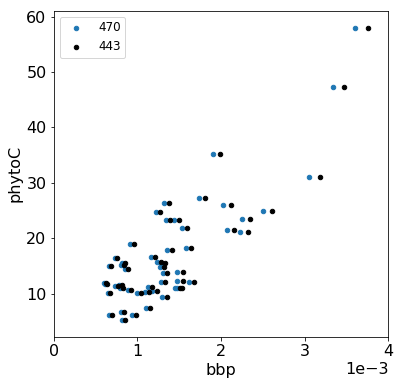

In [10]:
f, ax = pl.subplots(figsize=(6, 6))
df.plot.scatter('bbp_470', 'phytoC', ax=ax, label='470')
df.plot.scatter('bbp_443', 'phytoC', ax=ax, label='443', color='k', marker='o')
ax.set_xlabel('bbp')
ax.legend(fontsize=12)
ax.set_xlim(0, 0.004)

In [11]:
df2 = pd.DataFrame(['EPO'] * 32 + ['AMT-22'] * 19, columns=['location'])

In [12]:
df = pd.concat((df, df2),axis=1)
#df.append(pd.DataFrame(['EPO'] * 32 + ['AMT-22'] * 19, columns=['location']), sort=False)

In [13]:
df.head()

,bbp_470,bbp_443,phytoC,location
0,0.00132,0.001376,26.41,EPO
1,0.00116,0.001209,16.63,EPO
2,0.00158,0.001647,18.25,EPO
3,0.00130,0.001355,9.47,EPO
4,0.00122,0.001272,24.68,EPO


In [14]:
df['location_code'] = df.location.astype('category').cat.codes

In [15]:
df.tail()

,bbp_470,bbp_443,phytoC,location,location_code
46,0.001614,0.001683,12.04,AMT-22,0
47,0.001306,0.001361,13.78,AMT-22,0
48,0.003601,0.003753,58.00,AMT-22,0
49,0.003054,0.003183,31.13,AMT-22,0
50,0.003333,0.003474,47.26,AMT-22,0


In [17]:
bbp_443_std = df.bbp_443.std()
bbp_443_mean = df.bbp_443.mean()
df.insert(2, 'bbp_443_s', value=(df.bbp_443 - bbp_443_mean) / bbp_443_std)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 6 columns):
bbp_470          51 non-null float64
bbp_443          51 non-null float64
bbp_443_s        51 non-null float64
phytoC           51 non-null float64
location         51 non-null object
location_code    51 non-null int8
dtypes: float64(4), int8(1), object(1)
memory usage: 2.1+ KB


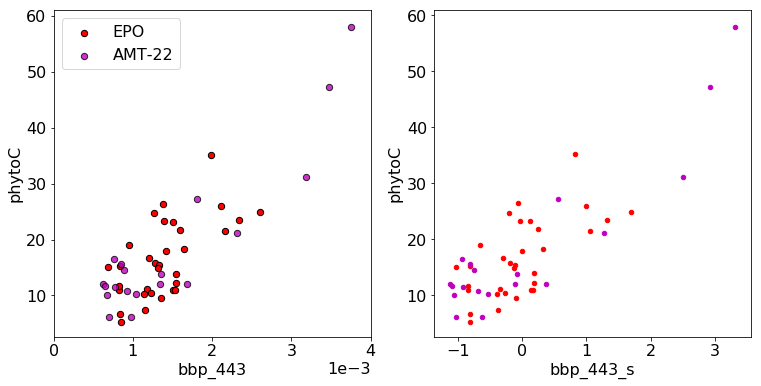

In [19]:
f, ax = pl.subplots(ncols=2, figsize=(12.5, 6))
df.loc[df.location=='EPO'].plot.scatter('bbp_443', 'phytoC', color='r', ax=ax[0],
                                       label='EPO', s=40, edgecolor='k',
                                       alpha=1)
df.loc[df.location!='EPO'].plot.scatter('bbp_443', 'phytoC', color='m', ax=ax[0],
                                       label='AMT-22', s=40, edgecolor='k', alpha=0.8)
df.loc[df.location=='EPO'].plot.scatter('bbp_443_s', 'phytoC', color='r', ax=ax[1])
df.loc[df.location!='EPO'].plot.scatter('bbp_443_s', 'phytoC', color='m', ax=ax[1])
ax[0].set_xlim(0, 0.004);
ax[0].legend(fontsize=16);

In [28]:
with pm.Model() as m_pooled_s:
    h_icept_sd = pm.HalfCauchy('h_icept_sd', 2.5)
    h_slope_sd = pm.HalfCauchy('h_slope_sd', 2.5)
    icept_s = pm.Normal('icept_s', 0, h_icept_sd)
    slope_s = pm.Normal('slope_s', 0, h_slope_sd)
    sigma = pm.HalfCauchy('sigma', 5)
    mu_ = icept_s + df.bbp_443_s.values * slope_s
    y_lik = pm.Normal('likelihood', mu=mu_, sd=sigma, observed=df.phytoC.values)
    trace_pooled_s = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope_s, icept_s, h_slope_sd, h_icept_sd]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:04<00:00, 3263.01draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6856966702526074, but should be close to 0.8. Try to increase the number of tuning steps.


In [30]:
with pm.Model() as m_pooled:
    h_icept_sd = pm.HalfCauchy('h_icept_sd', 10)
    h_slope_sd = pm.HalfCauchy('h_slope_sd', 10)
    icept = pm.Normal('icept_', 0, h_icept_sd)
    slope_div1000 = pm.Normal('slope_div1000', 0, h_slope_sd)
    sigma = pm.HalfCauchy('sigma', 5)
    mu_ = icept + df.bbp_443.values * 1000 * slope_div1000
    y_lik = pm.Normal('likelihood', mu=mu_, sd=sigma, observed=df.phytoC.values)
    slope = pm.Deterministic('slope', slope_div1000 * 1000)
    trace_pooled = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope_div1000, icept_, h_slope_sd, h_icept_sd]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2487.37draws/s]
There were 387 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6226056730676025, but should be close to 0.8. Try to increase the number of tuning steps.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


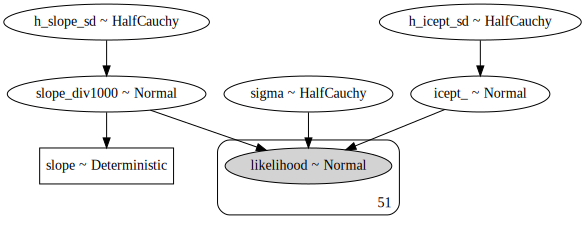

In [31]:
pm.model_to_graphviz(m_pooled)

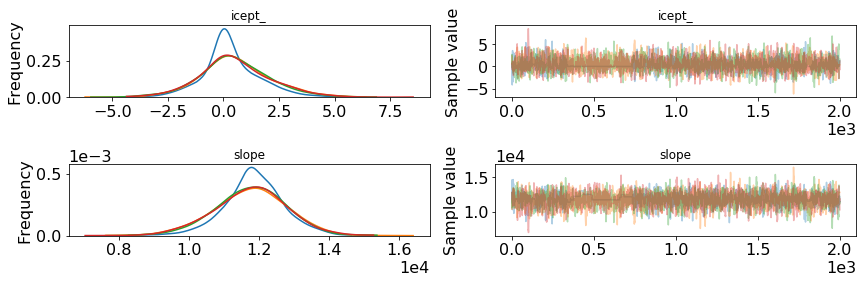

In [32]:
pm.traceplot(trace_pooled, varnames=['icept_', 'slope']);

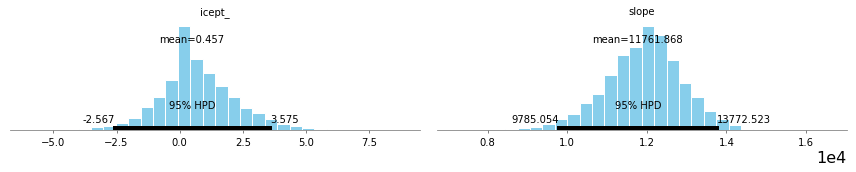

In [33]:
pm.plot_posterior(trace_pooled, varnames=['icept_', 'slope']);

In [34]:
icept_pooled_ = trace_pooled.get_values('icept_')
slope_pooled_ = trace_pooled.get_values('slope')

In [37]:
mdl_dict = dict(trace_div1000=trace_pooled,
               intercept = icept_pooled_,
               slope = slope_pooled_
               )
with open('./pklJar/pooled_params.pkl', 'wb') as fb:
    pickle.dump(mdl_dict, fb, protocol=pickle.HIGHEST_PROTOCOL)